In [1]:
import sys, os
ROOT = os.path.abspath("..")   # go up one directory from notebooks/
if ROOT not in sys.path:
    sys.path.append(ROOT)

print(ROOT)  


c:\Users\tdiks\Documents\PINN


In [2]:
from src2.networks import get_all_networks
from src2.config import CONFIG

from src2.sampling import (
    sample_domain_points,
    sample_top_surface,
    sample_interface,
    sample_far_field
)

from src2.losses import total_loss

from src2.pde_residuals import (
    residual_layer_coupled,
    residual_halfspace
)

from src2.boundary_conditions import (
    top_surface_bc,
    interface_layer_halfspace,
    halfspace_far_field_bc
)


# — Torch + Device

In [3]:
import torch
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


# Build-Models

In [4]:
model_layer, model_half = get_all_networks()

model_layer.to(DEVICE)
model_half.to(DEVICE)


PINN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): Tanh()
    (16): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Load Config & Geometry

In [5]:
geom = CONFIG["GEOMETRY"]

params_layer = CONFIG["LAYER"]
params_half  = CONFIG["HALFSPACE"]
dispersion = []   # <-- DEFINE DISPERSION HERE


# Define trainable phase velocity (c)

In [6]:
c = torch.nn.Parameter(
    torch.tensor(
        (params_layer["mu44_0"] / params_layer["rho_0"])**0.5,
        device=DEVICE
    )
)


# Optimizer

In [7]:
optimizer = optim.Adam(
    list(model_layer.parameters()) +
    list(model_half.parameters()) +
    [c],
    lr=1e-3
)


# Training Loop (Simple + Transparent)

In [8]:
dispersion = []   # <-- define once, BEFORE this block

# Training Loop (Dispersion)
k_values = torch.linspace(
    CONFIG["GEOMETRY"]["k_min"],
    CONFIG["GEOMETRY"]["k_max"],
    CONFIG["GEOMETRY"]["num_k"]
)

for k in k_values:

    # Build-Models
    model_layer, model_half = get_all_networks()
    model_layer.to(DEVICE)
    model_half.to(DEVICE)

    # Define trainable phase velocity (c)
    c = torch.nn.Parameter(
        torch.tensor(
            (params_layer["mu44_0"] / params_layer["rho_0"])**0.5,
            device=DEVICE
        )
    )

    optimizer = optim.Adam(
        list(model_layer.parameters()) +
        list(model_half.parameters()) +
        [c],
        lr=1e-3
    )

    # -------- INNER TRAINING LOOP --------
    for epoch in range(1, 100):

        z_layer, z_half = sample_domain_points(3000, geom)
        z_top = sample_top_surface(1000, geom)
        z_int = sample_interface(1000)
        z_far = sample_far_field(1000, geom)

        optimizer.zero_grad()

        loss, logs = total_loss(
            model_layer,
            model_half,
            z_layer,
            z_half,
            z_top,
            z_int,
            z_far,
            params_layer,
            params_half,
            k.item()* geom["H"],   # <-- correct
            c,
            w_pde=1.0,
            w_bc=0.1,
            w_int=0.01,
            w_far=0.001,
        )
    

        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print(
                f"k={k.item():.2f} | "
                f"Epoch {epoch} | "
                f"Loss={loss.item():.3e} |"
                f"PDE={logs['pde']:.2e} | "
                f"BC={logs['bc_top']:.2e} | "
                f"INT={logs['interface']:.2e} | "
                f"FAR={logs['far']:.2e}"
            )

    
    dispersion.append([k.item(), c.item()])


k=0.10 | Epoch 20 | Loss=5.814e+09 |PDE=4.95e+09 | BC=2.00e+09 | INT=6.62e+10 | FAR=2.76e-09
k=0.10 | Epoch 40 | Loss=4.621e+08 |PDE=4.51e+08 | BC=7.29e+07 | INT=3.48e+08 | FAR=1.05e-09
k=0.10 | Epoch 60 | Loss=9.294e+07 |PDE=8.74e+07 | BC=4.11e+07 | INT=1.43e+08 | FAR=1.64e-09
k=0.10 | Epoch 80 | Loss=1.346e+07 |PDE=1.30e+07 | BC=2.51e+06 | INT=2.14e+07 | FAR=1.18e-10
k=0.12 | Epoch 20 | Loss=4.839e+09 |PDE=4.67e+09 | BC=1.38e+09 | INT=3.17e+09 | FAR=3.71e-09
k=0.12 | Epoch 40 | Loss=3.958e+08 |PDE=3.68e+08 | BC=2.67e+08 | INT=9.37e+07 | FAR=1.76e-10
k=0.12 | Epoch 60 | Loss=3.335e+07 |PDE=2.92e+07 | BC=3.10e+07 | INT=1.04e+08 | FAR=8.20e-11
k=0.12 | Epoch 80 | Loss=1.199e+07 |PDE=1.17e+07 | BC=2.38e+06 | INT=7.67e+06 | FAR=2.26e-12
k=0.15 | Epoch 20 | Loss=7.734e+09 |PDE=7.49e+09 | BC=1.12e+09 | INT=1.31e+10 | FAR=5.76e-11
k=0.15 | Epoch 40 | Loss=1.033e+09 |PDE=9.72e+08 | BC=2.98e+08 | INT=3.13e+09 | FAR=1.89e-09
k=0.15 | Epoch 60 | Loss=9.695e+07 |PDE=8.80e+07 | BC=7.84e+07 | INT=1

In [9]:
torch.save({
    "model_layer": model_layer.state_dict(),
    "model_half": model_half.state_dict(),
    "c": c.detach().cpu()
}, "dispersion_pinn.pth")

print("Model saved.")


Model saved.


Choose time & y-location

In [10]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

H = geom["H"]   # layer thickness
L = geom["L"]   # half-space depth


Create a point in each layer

In [11]:
# z-grid for plotting / post-processing

z_layer = torch.linspace(-H, 0.0, 200).reshape(-1, 1).to(DEVICE)
z_half  = torch.linspace(0.0, L, 200).reshape(-1, 1).to(DEVICE)


Feed to model

In [12]:
with torch.no_grad():

    scale = 1e-2
# Layer (complex amplitude)   
    
V_layer = model_layer(z_layer)
V_R = scale * V_layer[:, 0:1]
V_I = scale * V_layer[:, 1:2]
# Half-space (real amplitude)
V_half = scale * model_half(z_half)



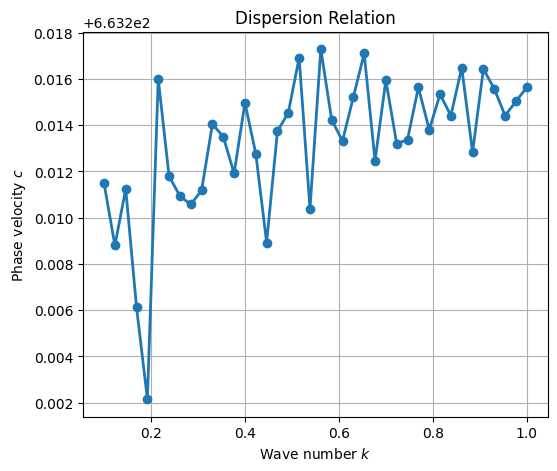

In [13]:
import matplotlib.pyplot as plt
import torch

# dispersion: shape (N, 2) → [k, c]
dispersion = torch.tensor(dispersion)
# dispersion: shape (N, 2) → [k, c]
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]


plt.figure(figsize=(6,5))
plt.plot(k_vals, c_vals, 'o-', linewidth=2, markersize=6)

plt.xlabel("Wave number $k$")
plt.ylabel("Phase velocity $c$")
plt.title("Dispersion Relation")
plt.grid(True)

plt.show()


Plot Disperion curves


Layer properties:
  μ₆₆ = 5.00e+09 Pa
  ρ = 9890 kg/m³
  c_ref = √(μ₆₆/ρ) = 711.0 m/s
  H = 1.0


C:\Users\tdiks\AppData\Local\Temp\ipykernel_10544\2211015661.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dispersion = torch.tensor(dispersion)


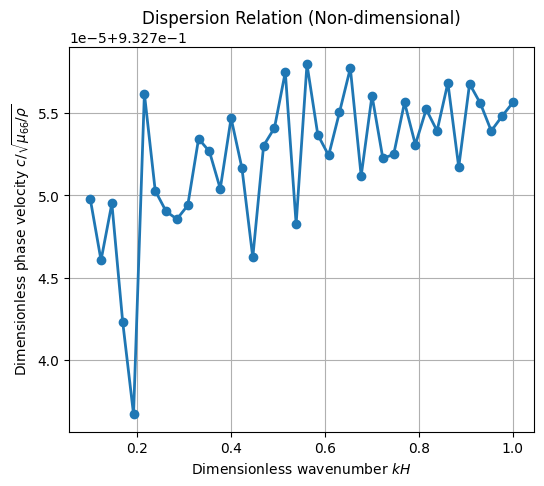


Dispersion data (non-dimensional):
   kH        c/c_ref
   0.100     0.933
   0.123     0.933
   0.146     0.933
   0.169     0.933
   0.192     0.933
   0.215     0.933
   0.238     0.933
   0.262     0.933
   0.285     0.933
   0.308     0.933
   0.331     0.933
   0.354     0.933
   0.377     0.933
   0.400     0.933
   0.423     0.933
   0.446     0.933
   0.469     0.933
   0.492     0.933
   0.515     0.933
   0.538     0.933
   0.562     0.933
   0.585     0.933
   0.608     0.933
   0.631     0.933
   0.654     0.933
   0.677     0.933
   0.700     0.933
   0.723     0.933
   0.746     0.933
   0.769     0.933
   0.792     0.933
   0.815     0.933
   0.838     0.933
   0.862     0.933
   0.885     0.933
   0.908     0.933
   0.931     0.933
   0.954     0.933
   0.977     0.933
   1.000     0.933


In [14]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Your dispersion data
dispersion = torch.tensor(dispersion)
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]

# Material properties for layer (from your config)
mu66_layer = 5.0e9  # Pa
rho_layer = 9890.0  # kg/m³
H = 1.0  # Layer thickness (non-dimensional)

# Calculate reference velocity: √(μ₆₆/ρ) for layer
c_ref_layer = np.sqrt(mu66_layer / rho_layer)  # Reference shear speed

print(f"Layer properties:")
print(f"  μ₆₆ = {mu66_layer:.2e} Pa")
print(f"  ρ = {rho_layer:.0f} kg/m³")
print(f"  c_ref = √(μ₆₆/ρ) = {c_ref_layer:.1f} m/s")
print(f"  H = {H}")

# Non-dimensionalize
kH = k_vals * H                     # Dimensionless wavenumber
c_norm = c_vals / c_ref_layer       # Dimensionless phase velocity

# Plot
plt.figure(figsize=(6, 5))
plt.plot(kH, c_norm, 'o-', linewidth=2, markersize=6)

plt.xlabel("Dimensionless wavenumber $kH$")
plt.ylabel("Dimensionless phase velocity $c/\\sqrt{\\mu_{66}/\\rho}$")
plt.title("Dispersion Relation (Non-dimensional)")
plt.grid(True)

plt.show()

# Print the data
print("\nDispersion data (non-dimensional):")
print("   kH        c/c_ref")
for i in range(len(kH)):
    print(f"   {kH[i]:.3f}     {c_norm[i]:.3f}")

C:\Users\tdiks\AppData\Local\Temp\ipykernel_10544\2954668902.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dispersion = torch.tensor(dispersion)


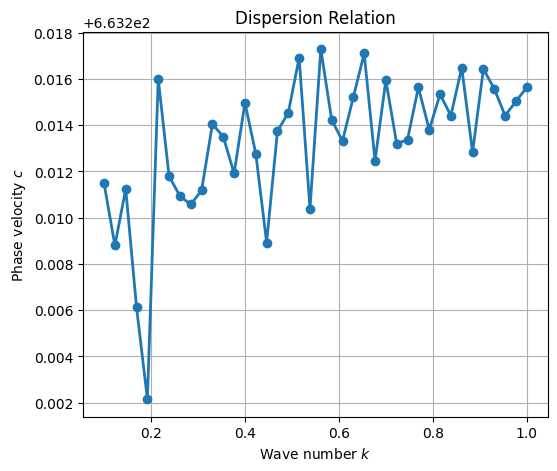

In [15]:
import matplotlib.pyplot as plt
import torch

# dispersion: shape (N, 2) → [k, c]
dispersion = torch.tensor(dispersion)
# dispersion: shape (N, 2) → [k, c]
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]


plt.figure(figsize=(6,5))
plt.plot(k_vals, c_vals, 'o-', linewidth=2, markersize=6)

plt.xlabel("Wave number $k$")
plt.ylabel("Phase velocity $c$")
plt.title("Dispersion Relation")
plt.grid(True)

plt.show()


In [16]:
k_vals

tensor([0.1000, 0.1231, 0.1462, 0.1692, 0.1923, 0.2154, 0.2385, 0.2615, 0.2846,
        0.3077, 0.3308, 0.3538, 0.3769, 0.4000, 0.4231, 0.4462, 0.4692, 0.4923,
        0.5154, 0.5385, 0.5615, 0.5846, 0.6077, 0.6308, 0.6538, 0.6769, 0.7000,
        0.7231, 0.7462, 0.7692, 0.7923, 0.8154, 0.8385, 0.8615, 0.8846, 0.9077,
        0.9308, 0.9538, 0.9769, 1.0000])

In [17]:
c_vals

tensor([663.2115, 663.2088, 663.2112, 663.2061, 663.2021, 663.2160, 663.2118,
        663.2109, 663.2106, 663.2112, 663.2141, 663.2135, 663.2119, 663.2150,
        663.2128, 663.2089, 663.2137, 663.2145, 663.2169, 663.2104, 663.2173,
        663.2142, 663.2133, 663.2152, 663.2171, 663.2125, 663.2159, 663.2132,
        663.2134, 663.2156, 663.2138, 663.2153, 663.2144, 663.2165, 663.2128,
        663.2164, 663.2156, 663.2144, 663.2150, 663.2156])